In [1]:
import requests
import zipfile
import io
import os

url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/brain-tumor.zip"

response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        extract_dir = "extracted_files"
        os.makedirs(extract_dir, exist_ok=True)
        zip_ref.extractall(extract_dir)
else:
    print("Failed to download the ZIP file.")

In [2]:
extracted_folders = os.listdir(extract_dir)
extracted_folders

['train', 'valid']

In [3]:
import os

# Lists to store file paths for images and labels
train_image_paths = []
valid_image_paths = []
train_label_paths = []
valid_label_paths = []

for folder in extracted_folders:
    folder_path = os.path.join(extract_dir, folder)

    if os.path.isdir(folder_path):
        print(f"Folder found: {folder}")

        if folder == "train":
            # Get all training images and labels
            train_images = os.listdir(os.path.join(folder_path, "images"))
            train_labels = os.listdir(os.path.join(folder_path, "labels"))

            # Store the full paths for images and labels
            for image_name in train_images:
                image_path = os.path.join(folder_path, "images", image_name)
                train_image_paths.append(image_path)
            for label_name in train_labels:
                label_path = os.path.join(folder_path, "labels", label_name)
                train_label_paths.append(label_path)
            
            print(f"Stored paths for {len(train_image_paths)} training images and {len(train_label_paths)} training labels.")

        elif folder == "valid":
            # Get all validation images and labels
            valid_images = os.listdir(os.path.join(folder_path, "images"))
            valid_labels = os.listdir(os.path.join(folder_path, "labels"))

            # Store the full paths for images and labels
            for image_name in valid_images:
                image_path = os.path.join(folder_path, "images", image_name)
                valid_image_paths.append(image_path)
            for label_name in valid_labels:
                label_path = os.path.join(folder_path, "labels", label_name)
                valid_label_paths.append(label_path)
            
            print(f"Stored paths for {len(valid_image_paths)} validation images and {len(valid_label_paths)} validation labels.")

# Print summary
print(f"Total training image paths: {len(train_image_paths)}")
print(f"Total training label paths: {len(train_label_paths)}")
print(f"Total validation image paths: {len(valid_image_paths)}")
print(f"Total validation label paths: {len(valid_label_paths)}")


Folder found: train
Stored paths for 893 training images and 878 training labels.
Folder found: valid
Stored paths for 223 validation images and 223 validation labels.
Total training image paths: 893
Total training label paths: 878
Total validation image paths: 223
Total validation label paths: 223


In [4]:
# use paths to turn images and labels into arrays
train_image_paths[0]

'extracted_files/train/images/125.jpg'

In [5]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 201.9 MB/s eta 0:00:0000:01


In [6]:
import cv2
import numpy as np

def processImage(img_path):
    image = cv2.imread(img_path)
    img_array = np.array(image) # convert image into numpy 
    img_resized = cv2.resize(img_array, (224, 224))  # Resize to a standard size (224x224 as an example)
    
    return img_resized.flatten()

def processDirectory(dir_array):
    image_data = []
    for img_path in dir_array:
        img = processImage(img_path)
        image_data.append(img)
    return image_data

from concurrent.futures import ProcessPoolExecutor

def processDirectoryParallel(dir_array, max_workers=4):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        image_data = list(executor.map(processImage, dir_array))
    return image_data

In [7]:
from concurrent.futures import ProcessPoolExecutor

def processDirectoryParallel(dir_array, max_workers=4):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        image_data = list(executor.map(processImage, dir_array))
    return image_data

In [8]:
import numpy as np

X_train = processDirectoryParallel(train_image_paths, max_workers=4)
X_train = np.array(X_train)
print(X_train.shape) # (893, 150528), 224 x 224 is 50,000 but due to RGB it is triple that

(893, 150528)


In [9]:
X_val = processDirectoryParallel(valid_image_paths, max_workers=4)
X_val = np.array(X_val)
print(X_val.shape) 

(223, 150528)


In [10]:
def read_labels_from_files(label_paths):
    # Read labels from each file, extract the first character, and store them in a list
    labels = []
    for path in label_paths:
        with open(path, 'r') as file:
            label = file.read().strip()
            first_char = label[0] if label else ''  
            labels.append(first_char)
    
    return np.array(labels).reshape(-1, 1)

In [11]:
y_train = read_labels_from_files(train_label_paths)
y_val = read_labels_from_files(valid_label_paths)

In [12]:
y_train.shape #there are less training labels than training images

(878, 1)

In [13]:
# check for duplicate data, there is none
image_set = set(train_image_paths)
label_set = set(train_label_paths)

len(image_set)
len(label_set)

878

In [14]:
# get rid of the extensions and the directory path to find the missing labels
train_image_paths_no_ext = [os.path.splitext(path)[0] for path in train_image_paths]
train_label_paths_no_ext = [os.path.splitext(path)[0] for path in train_label_paths]

train_image_paths_base = [os.path.basename(path) for path in train_image_paths_no_ext]
train_label_paths_base = [os.path.basename(path) for path in train_label_paths_no_ext]

image_set = set(train_image_paths_base)
label_set = set(train_label_paths_base)

missing_set = image_set - label_set
missing_set

{'00360_108',
 '00360_114',
 '00360_115',
 '00360_120',
 '00360_122',
 '00360_126',
 '00360_129',
 '00364_107',
 '00364_113',
 '00364_119',
 '00364_120',
 '00364_125',
 '00364_127',
 '00406_98',
 '72 (12)'}

In [15]:
# use the missing set to remove the images without a label
train_images_base_dir = "extracted_files/train/images/"
train_image_paths_reduced = train_image_paths #create duplicate of train_images_paths array
for image in missing_set:
    full_path = train_images_base_dir + image + ".jpg"
    print(full_path)
    train_image_paths_reduced.remove(full_path)

extracted_files/train/images/00360_122.jpg
extracted_files/train/images/00364_127.jpg
extracted_files/train/images/00364_107.jpg
extracted_files/train/images/00364_113.jpg
extracted_files/train/images/72 (12).jpg
extracted_files/train/images/00360_108.jpg
extracted_files/train/images/00360_126.jpg
extracted_files/train/images/00360_120.jpg
extracted_files/train/images/00364_125.jpg
extracted_files/train/images/00360_114.jpg
extracted_files/train/images/00406_98.jpg
extracted_files/train/images/00364_120.jpg
extracted_files/train/images/00360_115.jpg
extracted_files/train/images/00364_119.jpg
extracted_files/train/images/00360_129.jpg


In [16]:
os.path.exists("extracted_files/train/images/00360_120.jpg")


True

In [17]:
'extracted_files/train/images/00360_120.jpg' in train_image_paths

False

In [18]:
len(train_image_paths_reduced)

878

In [19]:
# with a now reduced image paths array, i need to re create the datasets

X_train = processDirectoryParallel(train_image_paths, max_workers=4)
X_train = np.array(X_train)

X_test = processDirectoryParallel(valid_image_paths, max_workers=4)
X_test = np.array(X_val)

y_train = read_labels_from_files(train_label_paths)
y_test = read_labels_from_files(valid_label_paths)

y_train = y_train.ravel()
y_test = y_test.ravel() # turn the label array from 2d to 1d

In [20]:
print("Length of X_train is " + str(X_train.shape))
print("Length of y_train is " + str(y_train.shape))
print("Length of X_val is " + str(X_test.shape))
print("Length of y_val is " + str(y_test.shape))

Length of X_train is (878, 150528)
Length of y_train is (878,)
Length of X_val is (223, 150528)
Length of y_val is (223,)


In [21]:
# now that the data is ready we can start training the model for classification
# im going to start off by using the random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# test the performance of the classifier
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.52


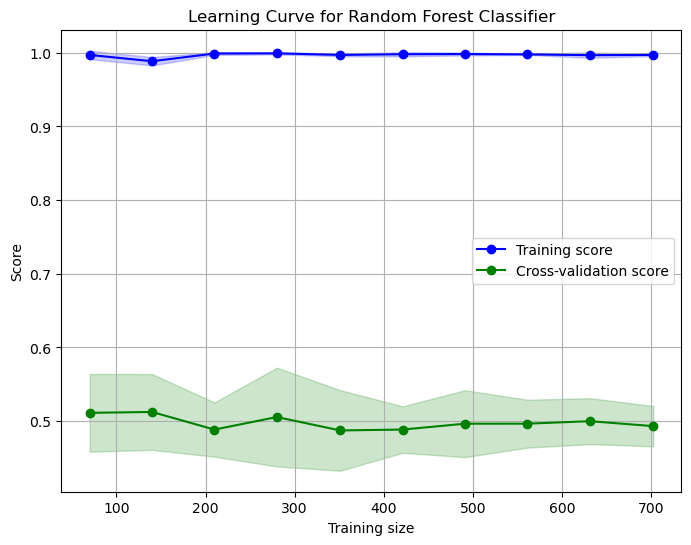

In [141]:
# terrible performance, 0.52 thats the same as guessing lets try plot the learning curve to get an idea of whats happening

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

def plot_learning_curve(classifier):
    # Generate the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation of training and testing scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker="o")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker="o")

    # Plot the fill between the curves to show the standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="blue", alpha=0.2)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green", alpha=0.2)

    # Add labels and title
    plt.title("Learning Curve for Random Forest Classifier")
    plt.xlabel("Training size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot_learning_curve(rf_classifier)

In [137]:
# the training score is 1.0 whilst the cross validation score is 0.5, this is a sign it is overfitting the model 
# need to regularise the model using LASSO, theres so many features its good to turn some of them down to 0

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=3)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

In [138]:
# test the performance of the classifier after a bit of regularisation
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.45


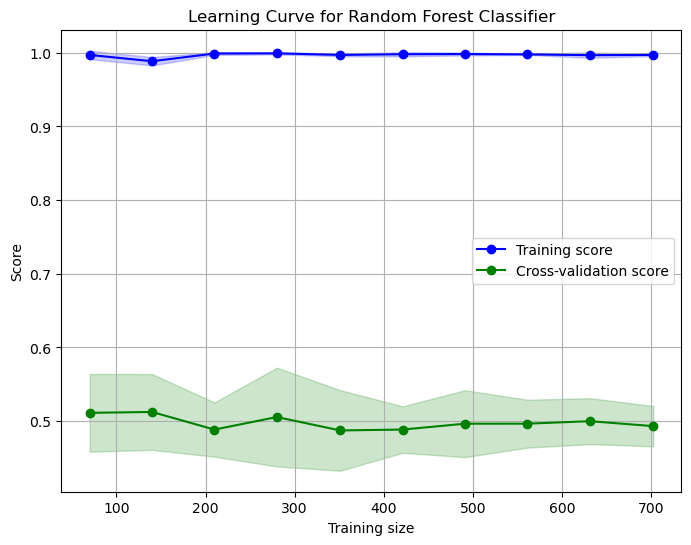

In [140]:
# the new accuracy is 0.45, it is somehow worse???, lets check the learning curves again
plot_learning_curve(rf_classifier)

In [144]:
# graph is generally the same, the training score is perfect but the validation score is poor
# lets try the oob score to make sure the generalisation is poor without using the test set

rf_classifier = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_classifier.fit(X_train, y_train)

# Access and print the OOB score
print(f"OOB Score: {rf_classifier.oob_score_}")


rf_classifier = RandomForestClassifier(oob_score=True, n_estimators=100, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=3)
rf_classifier.fit(X_train, y_train)

# Access and print the OOB score for the regularisation version
print(f"OOB Score (regularised): {rf_classifier.oob_score_}")

OOB Score: 0.5034168564920274
OOB Score (regularised): 0.5068337129840547


In [145]:
# the regularised version did slightly better but still terrible
# lets get the accuracy score on the training set to make sure it is overfitting or not

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set: {accuracy:.2f}")

Accuracy on training set: 1.00


In [146]:
#it got a perfect score on the training set, therefore the learning curves were accurate and its overfitting like crazy

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=3)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set: {accuracy:.2f}")

Accuracy on training set: 0.99


In [152]:
# lets do a grid search to find the best params for the random forest and see how well it performs

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV

rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1, 20, 50, 100, 150],   # Number of trees in the forest
    'max_depth': [None, 5, 10, 20, 30],   # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for best split
}

# Initialize GridSearchCV with RandomForest and the parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_es

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=None, max_feat

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_fe

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   5.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   5.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  10.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  15.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   2.4s
[CV] END max_depth=None, max_

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   3.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   2.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   2.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   2.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  10.9s
[CV] END max_depth=None, max_fea

[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.6s
[CV] END max_depth=None, ma

[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.8s
[CV] END max_depth=None, max_fe

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_sa

[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_sampl

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   7.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   7.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   7.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_sample

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   7.9s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1; total time=   0.4s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   1.2s
[CV] END max_depth=5, max_features=log2, min_samples_l

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_sample

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto,

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  13.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  13.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   9.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  15.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  14.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   9.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   9.1s
[CV] END max_depth=10, max_features=sqr

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  13.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   2.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=  13.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=  13.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   8.9s
[CV] END max_depth=10, max_features=sqrt,

[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.5s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.9s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150; total time=   1.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END max_depth=10, max_features=lo

[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1; total time=   0.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20; total time=   0.5s
[CV] END max_depth=10, max_features=log2, min_sam

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_s

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  15.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   2.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   2.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END max_depth=20, max_features=sqrt, min_sa

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  10.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  16.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  16.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  10.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  16.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  16.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.3s
[CV] END max_depth=20, max_features=s

[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   1.7s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=20, max_features=log2

[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END max_depth=20, max_features=log2, mi

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   2.6s
[CV] END max_depth=30, max_features=sqrt

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   2.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   2.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  16.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  16.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  16.7s
[CV] END max_depth=30, max_features=sqrt, 

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  14.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1125 fits failed out of a total of 3375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
538 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py", line 436, in _va

Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1}
Best Cross-validation Score: 0.525064935064935
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  13.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   2.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   4.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=  13.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=  14.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total

[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   1.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END max_depth=30, max_features=log2,

In [23]:
# Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1}
# Best Cross-validation Score: 0.525064935064935
# after waiting for an hour it still only got 0.52 accuracy, no better than guessing
# there is definitely something wrong with the data where the model cannot find any patterns 
# and as a result, is just overfitting whatever data there is

In [24]:
# with a now reduced image paths array, i need to re create the datasets

X_train = processDirectoryParallel(train_image_paths, max_workers=4)
X_train = np.array(X_train)

X_test = processDirectoryParallel(valid_image_paths, max_workers=4)
X_test = np.array(X_val)

y_train = read_labels_from_files(train_label_paths)
y_test = read_labels_from_files(valid_label_paths)

y_train = y_train.ravel()
y_test = y_test.ravel() # turn the label array from 2d to 1d

In [75]:
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def processImage(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_array = np.array(image) # convert image into numpy 
    img_resized = cv2.resize(img_array, (224, 224))  # Resize to a standard size (224x224 as an example)
    image_normalized = img_resized / 255.0
    
    return image_normalized.flatten()

def processDirectory(dir_array):
    image_data = []
    for img_path in dir_array:
        img = processImage(img_path)
        image_data.append(img)
    return image_data

def processDirectoryParallel(dir_array, max_workers=4):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        image_data = list(executor.map(processImage, dir_array))
    return image_data

In [76]:
#test out the model with reduced dimensions
X_train = processDirectoryParallel(train_image_paths, max_workers=4)
X_train = np.array(X_train)

X_test = processDirectoryParallel(valid_image_paths, max_workers=4)
X_test = np.array(X_test)

y_train = read_labels_from_files(train_label_paths)
y_test = read_labels_from_files(valid_label_paths)

y_train = y_train.ravel()
y_test = y_test.ravel()

In [54]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [56]:
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.48


In [82]:
with np.printoptions(threshold=np.inf):
    print(X_train[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [77]:
import pandas as pd
series = pd.Series(X_train[0])

# Display the Series
print(series)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
50171    0.0
50172    0.0
50173    0.0
50174    0.0
50175    0.0
Length: 50176, dtype: float64


In [78]:
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

In [79]:
y_train_df = pd.DataFrame(y_train)
y_val_df = pd.DataFrame(y_val)

In [80]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [81]:
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.49


In [72]:
# changing the datatype from numpy to dataframes didnt change anything
# make sure the dataset is balanced, loop through training labels to see if theres a equal number or trues and falses
true_count = 0
false_count = 0
for index in y_train:
    if index == '1':
        true_count = true_count + 1
    elif index == '0':
        false_count = false_count + 1

In [73]:
true_count

459

In [74]:
false_count

419

Matplotlib is building the font cache; this may take a moment.


IndexError: index 40 is out of bounds for axis 0 with size 40

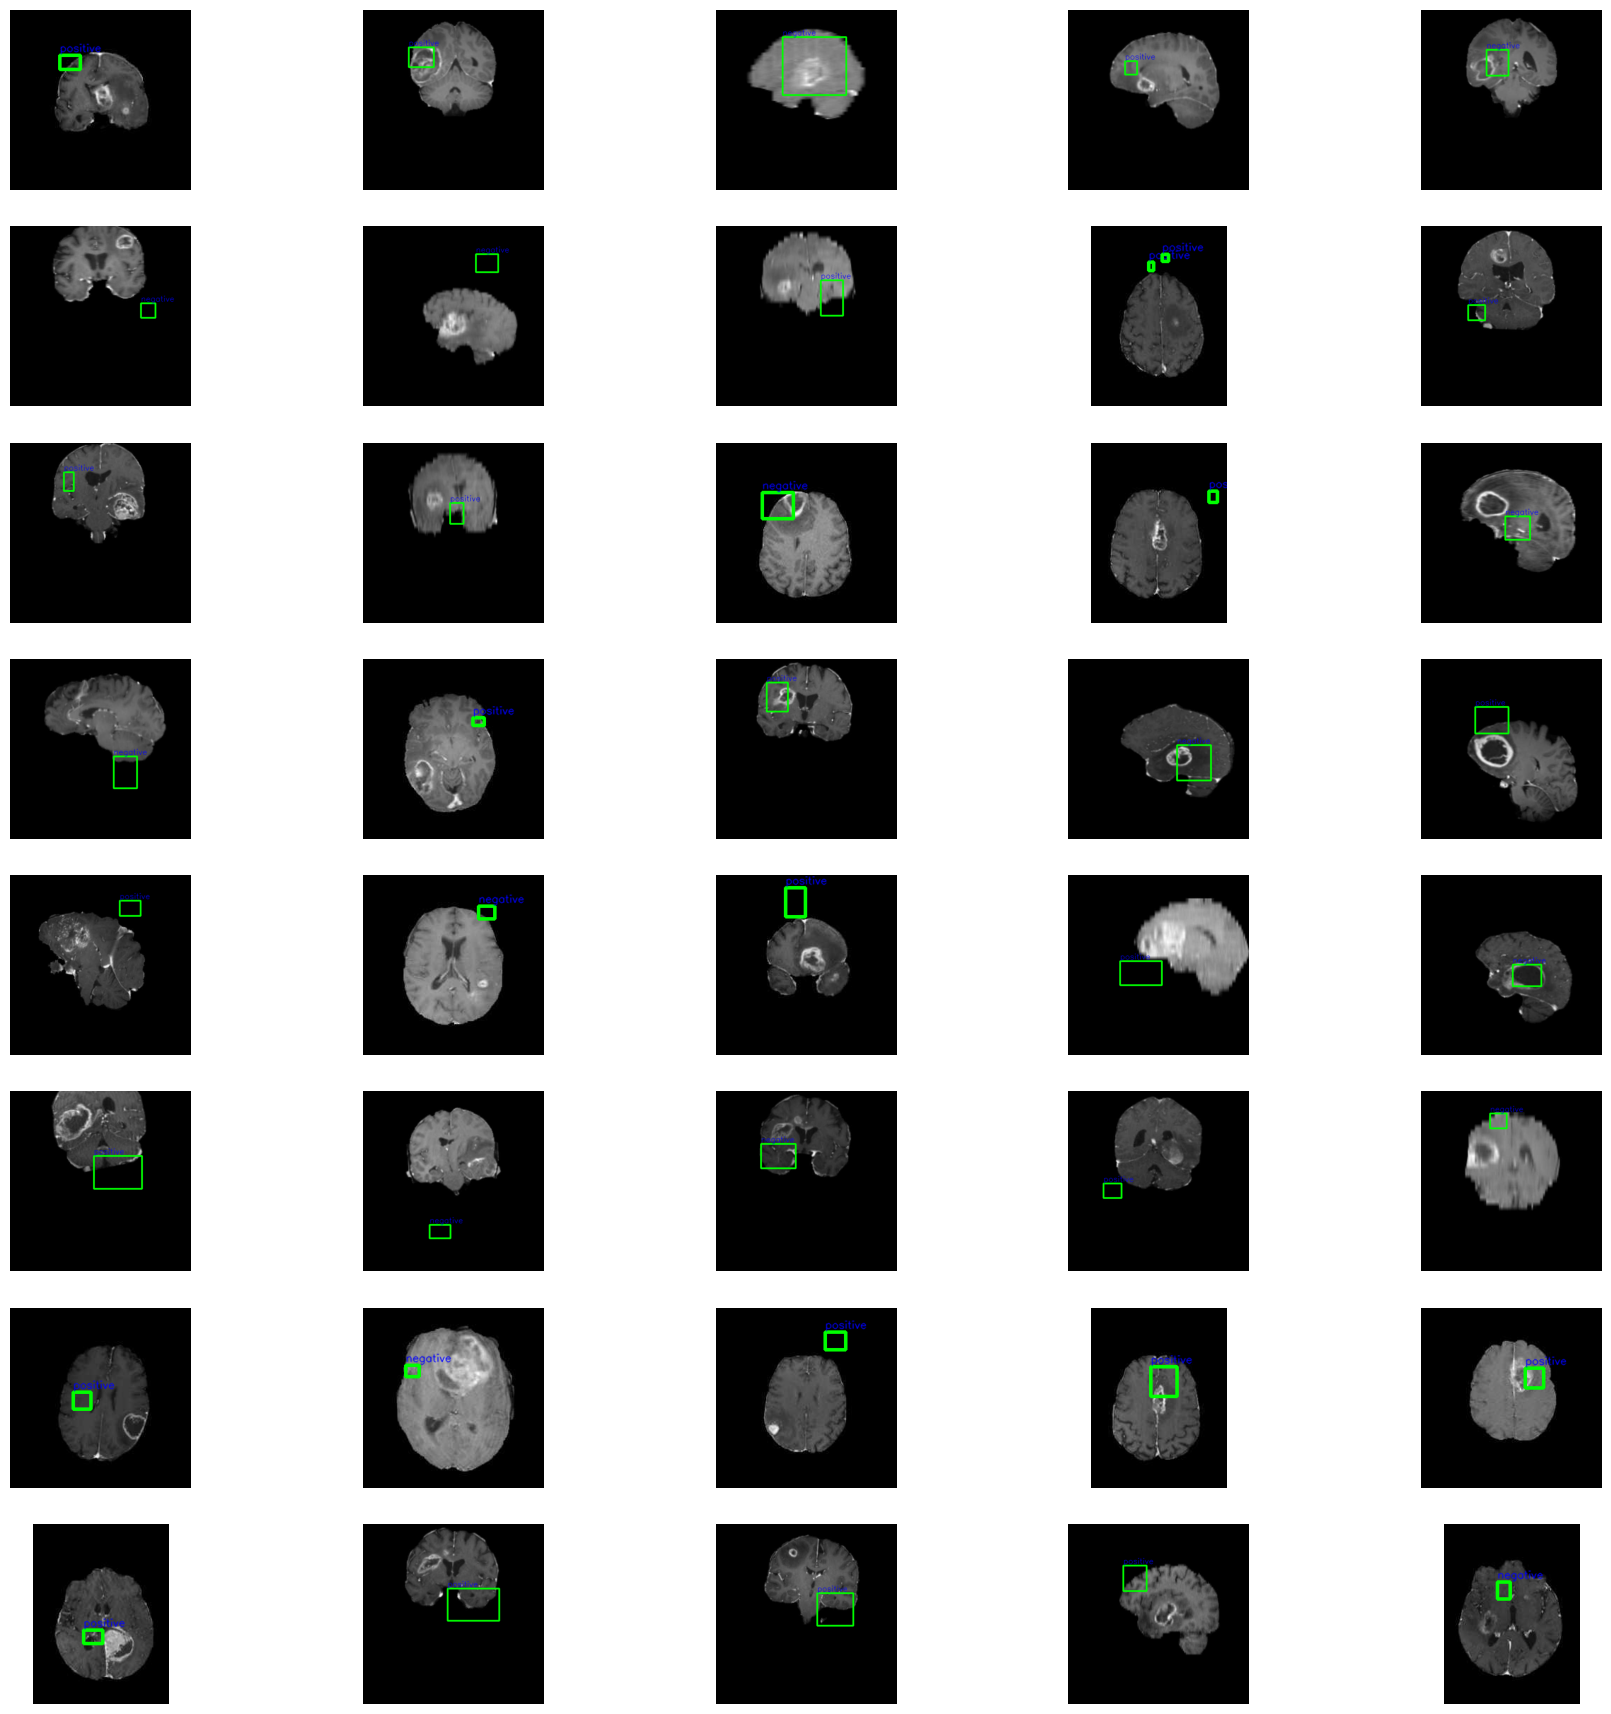

In [91]:
# the dataset seems balanced enough
# looked at kaggle and this guy drew a rectangle around the tumour before training it
class_names=['negative','positive']
import random
import cv2
import os
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8, 5, figsize=(22, 22))  
axs = axs.flatten() 

for i, image_file in enumerate(train_image_paths):
    image_path = image_file
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

    label_path = train_label_paths[i]
    
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")

        for label in labels:
            if len(label.split()) != 5: 
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])

            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

            text_scale = max(0.5, min(image.shape[1], image.shape[0]) / 700)
            text_thickness = max(1, int(text_scale * 2))
            classe = class_names[int(class_id)]  
            cv2.putText(
                image,
                classe,
                (x_min, max(y_min - 5, 0)),
                cv2.FONT_HERSHEY_SIMPLEX,
                text_scale,
                (0, 0, 255),
                text_thickness,
                cv2.LINE_AA,
            )
    
    axs[i].imshow(image)
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()